## Файл со 2й моделью  
Данный файл содержит модель основанную на простой нейросети и полученные в результате обучения метрики

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score,roc_curve,auc,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle

In [2]:
with open('./files/train_data.pkl', 'rb') as f:
    loaded_train_data = pickle.load(f)

# Загрузка тестовых данных
with open('./files/test_data.pkl', 'rb') as f:
    loaded_test_data = pickle.load(f)

# Извлечение признаков и меток
X_train_tfidf = loaded_train_data['features']
y_train = loaded_train_data['labels']

X_test_tfidf = loaded_test_data['features']
y_test = loaded_test_data['labels']

X_train_tensor = torch.tensor(X_train_tfidf, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [3]:
class ReviewDataset(Dataset):
    """
    Класс, представляющий датасет для отзывов.
    Параметры:
    X (torch.Tensor): Матрица признаков (TF-IDF).
    y (torch.Tensor): Метки классов.
    Методы:
    __len__: Возвращает количество образцов в датасете.
    __getitem__: Возвращает образец и его метку по индексу.
    """

    def __init__(self, X, y) -> None :
        """
        Инициализирует объект ReviewDataset.
        Параметры:
        X (torch.Tensor): Матрица признаков.
        y (torch.Tensor): Метки классов.
        """
        self.X = X
        self.y = y

    def __len__(self) -> int:
        """
        Возвращает количество образцов в датасете.
        Возвращает:
        int: Количество образцов.
        """
        return len(self.y)

    def __getitem__(
            self,
            idx : int
    )->tuple[torch.Tensor, torch.Tensor]:
        """
        Возвращает образец и его метку по индексу.
        Параметры:
        idx (int): Индекс образца.
        Возвращает:
        tuple: Образец (torch.Tensor) и его метка (torch.Tensor).
        """
        return self.X[idx], self.y[idx]
        
class SentimentModel(nn.Module):
    """
    Нейронная сеть для анализа настроений на основе логистической регрессии.
    Параметры:
    input_dim (int): Размер входного слоя (количество признаков).
    Методы:
    forward: Прямой проход через сеть. Возвращает вероятность положительного класса.
    """

    def __init__(
            self,
            input_dim : int
    ) -> None:
        """
        Инициализирует модель SentimentModel.
        Параметры:
        input_dim (int): Размер входного слоя.
        """
        super(SentimentModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(
            self,
            x : torch.Tensor
    ) ->torch.Tensor:
        """
        Прямой проход через нейронную сеть.
        Параметры:
        x (torch.Tensor): Входной тензор.
        Возвращает:
        torch.Tensor: Вероятность положительного класса.
        """
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [4]:
train_dataset = ReviewDataset(X_train_tensor, y_train_tensor)
test_dataset = ReviewDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
input_dim = X_train_tensor.shape[1]
model = SentimentModel(input_dim)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 15
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

Epoch 1/15, Loss: 0.3069533451914787
Epoch 2/15, Loss: 0.20410595026612283
Epoch 3/15, Loss: 0.17579855372607708
Epoch 4/15, Loss: 0.15022508049234748
Epoch 5/15, Loss: 0.11857959142774344
Epoch 6/15, Loss: 0.08458288320079446
Epoch 7/15, Loss: 0.054229272984154524
Epoch 8/15, Loss: 0.03103359597935341
Epoch 9/15, Loss: 0.016454724636115133
Epoch 10/15, Loss: 0.009378052129317076
Epoch 11/15, Loss: 0.006762451576173771
Epoch 12/15, Loss: 0.008198796487721847
Epoch 13/15, Loss: 0.007822119835577904
Epoch 14/15, Loss: 0.004166953155686497
Epoch 15/15, Loss: 0.0023888403859658866


Accuracy: 0.8765
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88      4961
         1.0       0.88      0.88      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



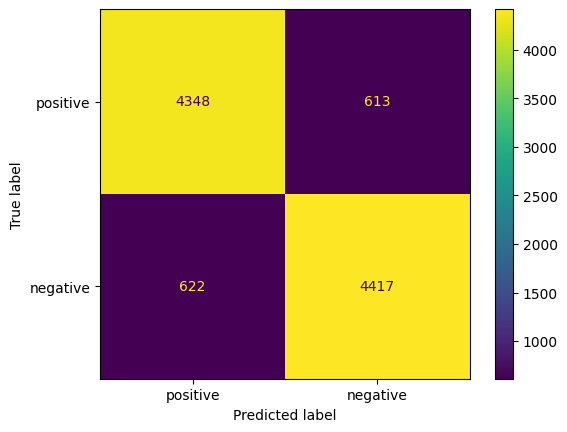

In [7]:
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())

accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_true, y_pred))

conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=["positive","negative"])
disp.plot()

In [9]:
input_dim = X_train_tensor.shape[1]
model = SentimentModel(input_dim)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

Epoch 1/10, Loss: 0.30841186325252057
Epoch 2/10, Loss: 0.20365945774763822
Epoch 3/10, Loss: 0.17632139325886964
Epoch 4/10, Loss: 0.1490097243770957
Epoch 5/10, Loss: 0.11736094619035721
Epoch 6/10, Loss: 0.08318819053694605
Epoch 7/10, Loss: 0.05061101761944592
Epoch 8/10, Loss: 0.028824430975690485
Epoch 9/10, Loss: 0.014848842281382531
Epoch 10/10, Loss: 0.008492208611196839


Accuracy: 0.876
              precision    recall  f1-score   support

         0.0       0.88      0.87      0.87      4961
         1.0       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



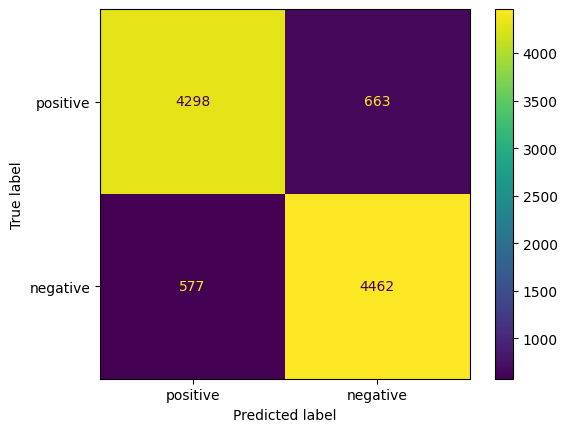

In [10]:
model.eval()
y_pred = []
y_true = []
prob = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        prob.extend(outputs)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())

accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_true, y_pred))

conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=["positive","negative"])
disp.plot()

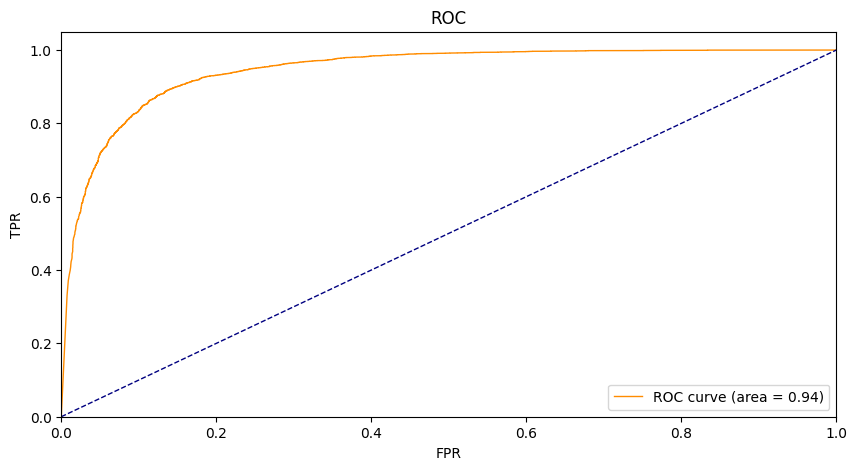

In [11]:
# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend()
plt.show()

Для данной модели изменение количества эпох обучения к существенным изменениям не приводит.  
Она также показывает довольно хорошие результаты, но немного хуже чем 1-я модель.  
Судя по матрице ошибок наша модель примерно в равной степени путает положительные и отрицательные отзывы, пусть процент этих ошибок и невел